In [1]:
import sys 
import io
import os
import cv2
import itertools
import collections
from sklearn.utils import shuffle 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
import random

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import tensorflow as tf

In [4]:
plt.style.use('seaborn-darkgrid')

# Aproximación con fuerza Bruta 
## Stacking CNN Layers

Ahora, vamos a desarrollar un modelo de CNNs para realizar una clasificación multiclase exploratoria ¿Qué dificultades tendrémos en obtener un modelo con un buen accurracy? ¿Qué tan grande deberá de ser la red. 

In [5]:
def set_seed(seed=42):
    """
    Esta función la seteamos para poder asegurar la reproducibilidad de nuestros
    resultados al futuro
    
    Seed es 42 porque es la respuesta a la última pregunta de la vida, el universo,
    y todo lo demás.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [6]:
# Definimos un MAINFOLDER 
#Este es nuestro directorio Training 
MAINFOLDER = '../input/brain-tumor-classification-mri/Training' #Así se accede en Kaggle
#MAINFOLDER = '../data/brain_MRI_Sartaj/Training/'  #Así accedemos en un locar con clon del repo

IMG_SIZE = 256

In [7]:
# Aquí cargamos todas las imágenes de entrenamiento
ds_train_ = image_dataset_from_directory(
    MAINFOLDER,
    labels='inferred',
    label_mode='categorical',
    image_size=[IMG_SIZE, IMG_SIZE],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    #color_mode="grayscale"
    color_mode="rgb"
)

Found 2870 files belonging to 4 classes.


In [8]:
#Acá cargamos todas las imágenes de prueba
ds_valid_ = image_dataset_from_directory(
    MAINFOLDER.replace('Training','Testing'),
    labels='inferred',
    label_mode='categorical',
    image_size=[IMG_SIZE, IMG_SIZE],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
    #color_mode="grayscale"
    color_mode="rgb"
)

Found 394 files belonging to 4 classes.


In [9]:
def convert_to_float(image, label):
    """
    Esta función garanriza dtypes similares para
    todas nuestras imágenes, así no tendremos problemas
    al futuro usando aceleradores. 
    """
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE #For improve CPU/GPU usage

#Acá cargamos hacemos el preprocessing de las imágenes
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Ahora vamos a construir nuestro modelo

In [10]:
model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),


    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),


    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),
    
    # Block Four
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),


    # Head
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(4, activation='softmax'),
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       1

A continuación definimos nuestro optimizador, nuestra función de pérdida y las métricas a reportar durante el entrenamiento

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001,epsilon=1e-07),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Definimos un early stopping 

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Y vamos a hacer el fitting del modelo

In [14]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    #batch_size=256,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
45/45 [==============================] - 41s 705ms/step - loss: 1.0478 - accuracy: 0.5573 - val_loss: 1.3515 - val_accuracy: 0.3579
Epoch 2/100
45/45 [==============================] - 11s 239ms/step - loss: 0.7029 - accuracy: 0.7428 - val_loss: 1.3141 - val_accuracy: 0.4391
Epoch 3/100
45/45 [==============================] - 11s 239ms/step - loss: 0.5491 - accuracy: 0.8374 - val_loss: 1.3002 - val_accuracy: 0.5964
Epoch 4/100
45/45 [==============================] - 11s 239ms/step - loss: 0.4373 - accuracy: 0.8639 - val_loss: 1.2666 - val_accuracy: 0.5964
Epoch 5/100
45/45 [==============================] - 11s 240ms/step - loss: 0.3497 - accuracy: 0.8952 - val_loss: 1.1684 - val_accuracy: 0.7005
Epoch 6/100
45/45 [==============================] - 11s 239ms/step - loss: 0.2585 - accuracy: 0.9326 - val_loss: 1.2094 - val_accuracy: 0.7310
Epoch 7/100
45/45 [==============================] - 11s 240ms/step - loss: 0.2263 - accuracy: 0.9521 - val_loss: 0.9868 - val_accuracy:

In [15]:
history_df = pd.DataFrame(history.history)

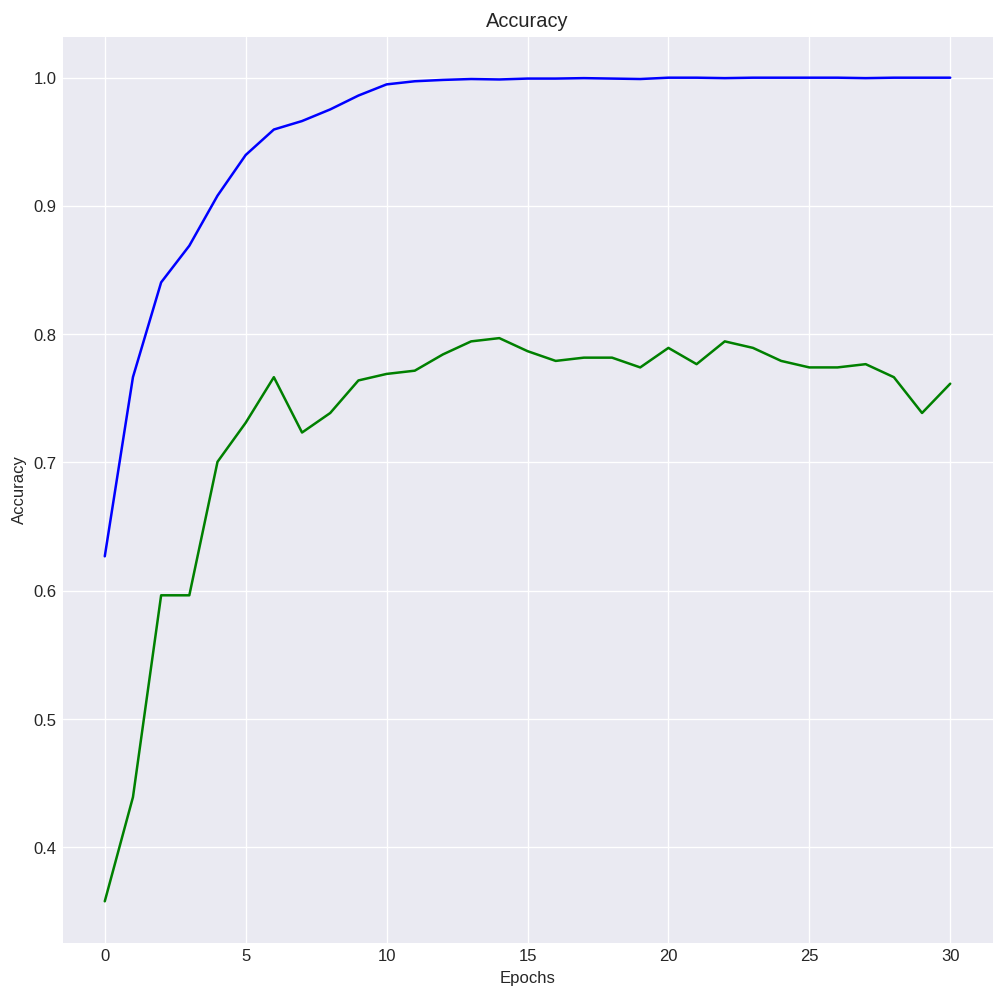

In [16]:
fig,ax = plt.subplots(1,1,figsize=(10,10),dpi=120)
ax.plot(history_df["accuracy"],c = "blue",label='train')
ax.plot(history_df["val_accuracy"],c = "green",label='test')
ax.set_title("Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.show()

In [17]:
#history_df.to_csv('History_run_1.csv')

Ahora, en [1] se aborda como _redes convolucionales planas_, tienen una limitante en aprendizaje y ello conlleva a un límite en accurracy y en la función de pérdida. Esta límitante se expresa aún añadiendo más capas convolucionales e incluso empeora el accurracy  mientras más capas se añaden. 

Vamos a hacer transfer learning: usar un [modelo pre-entrenado](https://www.tensorflow.org/api_docs/python/tf/keras/applications) de los disponibles en la base de TF y después hacer fine tunnig con nuestros datos. 

Solamente como flag el accurracy del modelo hasta ahora con una CNN plana de 4 hidden-layers es de $ \sim0.8$.

## Una segunda iteración: Transfer Lerarning & Data Augmentation

Ahora bien, en pos de poder aumentar los datos para la red vamos a realizar técnicas de data augmentation. Notemos que las MRI mantienen sus propiedades al recibir rotaciones y reflexiones, usando este hecho vamos a agregar en nuestro modelo secuencial una capa de Random Flip horizontal así la red recibirá nuevos datos y esperamos estas perturbaciones puendan ayudarnos en el entrenamiento posterior. 

In [18]:
model_augmented = keras.Sequential([
    
    #Adding a preprocessing part
    
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    #layers.experimental.preprocessing.RandomContrast(0.5),
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),


    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),


    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),
    
    # Block Four
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #layers.BatchNormalization(),


    # Head
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(4, activation='softmax'),
])

In [19]:
model_augmented.build(ds_train.element_spec[0].shape) #Como no hay capa de input tenemos que hacer un build para poder hacer un summary del modelo

In [20]:
model_augmented.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 128)      

In [21]:
model_augmented.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001,epsilon=1e-07),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [22]:
history_augmented = model_augmented.fit(
    ds_train,
    validation_data=ds_valid,
    #batch_size=256,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
45/45 [==============================] - 12s 245ms/step - loss: 1.0631 - accuracy: 0.5406 - val_loss: 1.3578 - val_accuracy: 0.4137
Epoch 2/100
45/45 [==============================] - 11s 240ms/step - loss: 0.7339 - accuracy: 0.7066 - val_loss: 1.3215 - val_accuracy: 0.5228
Epoch 3/100
45/45 [==============================] - 11s 243ms/step - loss: 0.5926 - accuracy: 0.7756 - val_loss: 1.2747 - val_accuracy: 0.5685
Epoch 4/100
45/45 [==============================] - 11s 241ms/step - loss: 0.4958 - accuracy: 0.8326 - val_loss: 1.2406 - val_accuracy: 0.5888
Epoch 5/100
45/45 [==============================] - 11s 241ms/step - loss: 0.4309 - accuracy: 0.8499 - val_loss: 1.1320 - val_accuracy: 0.6497
Epoch 6/100
45/45 [==============================] - 11s 242ms/step - loss: 0.3564 - accuracy: 0.8959 - val_loss: 1.1152 - val_accuracy: 0.6168
Epoch 7/100
45/45 [==============================] - 11s 241ms/step - loss: 0.3007 - accuracy: 0.9131 - val_loss: 1.0711 - val_accuracy:

In [23]:
history_augmented_df = pd.DataFrame(history_augmented.history)

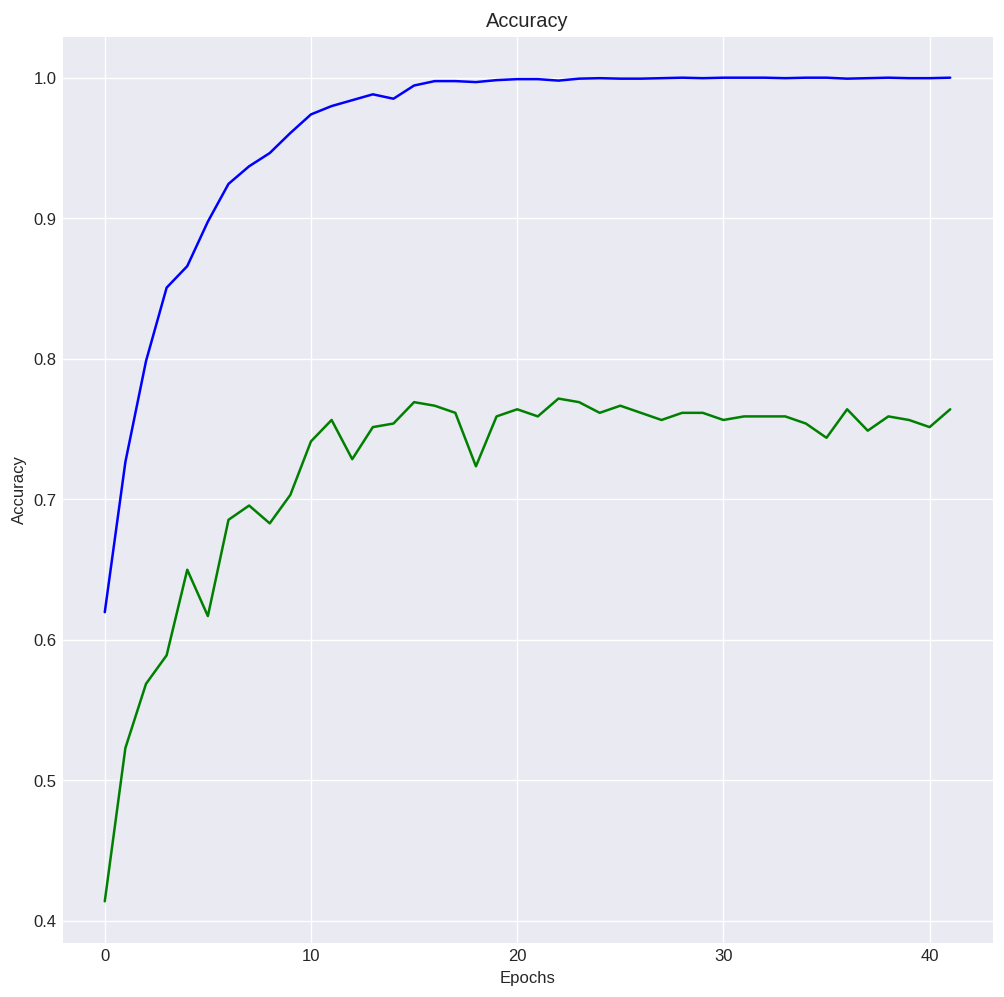

In [24]:
fig,ax = plt.subplots(1,1,figsize=(10,10),dpi=120)
ax.plot(history_augmented_df["accuracy"],c = "blue",label='train')
ax.plot(history_augmented_df["val_accuracy"],c = "green",label='test')
ax.set_title("Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.show()

## Transfer learning: EfficientNetB0 and ResNet50

En vista de los modelos anteriores y la necesidad de escalamiento probar otras arquitecturas es una necesidad que vamos a poder suplir añadiendo capas y mateniedo una _red plana_. Sin embargo entrenar redes de arquitecturas complejos necesita una gran cantidad de hardware y tiempo; cuando no tenemos ese tiempo disponible entra en juego el uso de técnicas de transfer lerning.

Esta ocasión vamos a trabjar con el modelo [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) y con [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50), estos modulos pre-entrenados los usaremos como **base** para nuestra red y los parámetros que entrenaremos serán los de la cabeza del modelo. 

Comenzaremos por trabajar con EfficientNetB0. 

In [25]:
# Ya sabemos que tenemos un file de input y de trainig:
MAINDIR = '../input/brain-tumor-classification-mri/Training'

In [26]:
# En el directio principal tenemos cuatro clases de imagenes ya pre-clasificadas
os.listdir(MAINDIR)

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [27]:
# Esta vez, para procurar tener la mayor cantidad data disponible en vamos cargar todo el data set,
# tanto trainig como testing en el mismo array y después vamos a partirlo en una parte de entranamiento
# y otro de testing. Ahora En el caso de EffNetB tenemos más libertar respecto al input shape pero no
# así con ResNet, razón por la cual vamos a fijar un reshape a (224,224,3). 

IMG_SHAPE = 224
X, Y = [],[]

for kind in os.listdir(MAINDIR):
    _dir = os.path.join(MAINDIR,kind)
    for img_path in map(lambda x:os.path.join(_dir,x),os.listdir(_dir)):
        img = cv2.imread(img_path)
        img = cv2.resize(img,(IMG_SHAPE,IMG_SHAPE))
        X.append(img)
    Y = Y+[kind]*len(os.listdir(_dir))
    

for kind in os.listdir(MAINDIR.replace('Training','Testing')):
    _dir = os.path.join(MAINDIR.replace('Training','Testing'),kind)
    for img_path in map(lambda x:os.path.join(_dir,x),os.listdir(_dir)):
        img = cv2.imread(img_path)
        img = cv2.resize(img,(IMG_SHAPE,IMG_SHAPE))
        X.append(img)
    Y = Y+[kind]*len(os.listdir(_dir))

In [28]:
X = np.array(X)
Y = np.array(Y)
print('Hay {} imágenes de shape {} de igual manera hay {} etiquetas'.format(X.shape[0],X.shape[1:],Y.shape[0]))

Hay 3264 imágenes de shape (224, 224, 3) de igual manera hay 3264 etiquetas


In [29]:
# Esta es la distribución de etiquetas
print(collections.Counter(Y))

Counter({'meningioma_tumor': 937, 'glioma_tumor': 926, 'pituitary_tumor': 901, 'no_tumor': 500})


In [30]:
# Ahora bien, hacemos label encoding de las etiquetas:
Y_ = Y.copy()
le = LabelEncoder()
Y = le.fit_transform(Y)

In [31]:
yDict = {i:Y_[Y==i][0] for i in np.unique(Y)}
print(yDict)

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}


In [32]:
# Ahora ese label encoding vamos a pasarlo a Hot Encoding
Y = keras.utils.to_categorical(Y,num_classes=4)
print(Y.shape)

(3264, 4)


In [33]:
# Ahora realizamos un shuffle de los datos 
x,y = shuffle(X,Y) # Notemos que a partir de acá cambiamos a x,y en lugar de X,Y

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42) # ajustamos la semilla a la misma que usamos al principio

In [35]:
# Ahora sí pasaremos a la construcción del modelo y a su entrenamiento, 
# partamos impotrando EffNetB0
from tensorflow.keras.applications import EfficientNetB0
effnetb0 = EfficientNetB0(weights = "imagenet",include_top=False,input_shape=(IMG_SHAPE,IMG_SHAPE,3))

16711680/16705208 [==============================] - 0s 0us/step


In [36]:
# Ahora vamos a definir nuestro modelo

model = effnetb0.output
model = layers.GlobalAveragePooling2D()(model)
model = layers.Dropout(0.5)(model)
model = layers.Dense(4,activation = "softmax")(model)

model = keras.models.Model(inputs = effnetb0.input,outputs = model)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accurracy", # let us hardcode the metric to be looking for
    mode="auto", # let tf to decide the minimun change var
    patience=5, # Harcoding patiente
    restore_best_weights=False, #this time we will no restore the model to best scenario
    verbose=1, # We want to read the console print
)

checkPoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = "model_effnetb7.h5",
    mode="auto", # let tf to decide if save the model or not
    monitor = "val_accurracy",
    save_best_only=True,
    verbose=1, # We want to read the console print
)

penalizeRule = tf.keras.callbacks.ReduceLROnPlateau(
    mode="auto", # let tf to decide the minimun change var
    monitor = "val_accurracy",
    factor = 0.3, # Penalize Factor for learning rate: if it's rearling too fast then reduce it
    min_delta = 0.001, # Threshold to decide a new optimum
    patience = 2, # Don't have memory beyond last 2 steps
    verbose=1, # We want to read the console print
)



In [40]:
history_effnetb0 = model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=50,
    callbacks=[early_stopping,checkPoint,penalizeRule],
    verbose=1
)

Epoch 1/50
82/82 [==============================] - 31s 257ms/step - loss: 0.9855 - accuracy: 0.5919 - val_loss: 0.8659 - val_accuracy: 0.6187
Epoch 2/50
82/82 [==============================] - 19s 227ms/step - loss: 0.3350 - accuracy: 0.8927 - val_loss: 0.6152 - val_accuracy: 0.7289
Epoch 3/50
82/82 [==============================] - 19s 229ms/step - loss: 0.1808 - accuracy: 0.9420 - val_loss: 0.5225 - val_accuracy: 0.8132
Epoch 4/50
82/82 [==============================] - 19s 228ms/step - loss: 0.1035 - accuracy: 0.9689 - val_loss: 0.5600 - val_accuracy: 0.7902
Epoch 5/50
82/82 [==============================] - 19s 228ms/step - loss: 0.0709 - accuracy: 0.9816 - val_loss: 0.5263 - val_accuracy: 0.8116
Epoch 6/50
82/82 [==============================] - 19s 228ms/step - loss: 0.0585 - accuracy: 0.9859 - val_loss: 0.4564 - val_accuracy: 0.8331
Epoch 7/50
82/82 [==============================] - 19s 228ms/step - loss: 0.0302 - accuracy: 0.9922 - val_loss: 0.4773 - val_accuracy: 0.8224

In [41]:
history_effnetb0_df = pd.DataFrame(history_effnetb7.history)

fig,ax = plt.subplots(1,2,dpi=120,figsize=(15,5))

ax[0].plot(history_effnetb0_df["accuracy"],color = "blue",label='train')
ax[0].plot(history_effnetb0_df["val_accuracy"],color = "green",label='test')
ax[0].set_title("Accuracy for Training and Test data")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].legend()


ax[1].plot(history_effnetb0_df["loss"],color = "blue",label='train')
ax[1].plot(history_effnetb0_df["val_loss"],color = "green",label='test')
ax[1].set_title("Categorical Crossentropy (loss) for Training and Test data")
ax[1].set_ylabel("Categorical Crossentropy")
ax[1].set_xlabel("Epochs")
ax[1].legend()


plt.show()

NameError: name 'history_effnetb7' is not defined

In [42]:
# Acá guardamos el model y el historial de entrenamiento por Epoch
if not 'saved_model' in os.listdir('.'):
    !mkdir -p saved_model
    
model.save('saved_model/model_effnetb0')

history_effnetb7_df.to_csv('EffNetB7_History_Accurracy.csv')

NameError: name 'history_effnetb7_df' is not defined

In [43]:
# Aquí vamosa probar el modelo con la data de test total
val_loss,val_acc = model.evaluate(x_test,y_test)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

21/21 [==============================] - 1s 39ms/step - loss: 0.1221 - accuracy: 0.9816
Validation Loss: 0.1220903992652893
Validation Accuracy: 0.9816232919692993


In [44]:
#Ahora veamos que tan bien o mal lo hizo respecto a los datos
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

y_test_label = np.argmax(y_test,axis=1)

unique,counts = np.unique(y_pred,return_counts=True)
print(unique,counts)

unique,counts = np.unique(y_test_label,return_counts=True)
print(unique,counts)

[0 1 2 3] [165 206 104 178]
[0 1 2 3] [167 203 104 179]


In [45]:
# Vamos a sacar un reporte de clasificación usando como
# KPIs: presicion, recall, f1-score y support
classificationReport = classification_report(y_true=y_test_label,y_pred=y_pred)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       167
           1       0.97      0.99      0.98       203
           2       0.98      0.98      0.98       104
           3       0.99      0.98      0.99       179

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



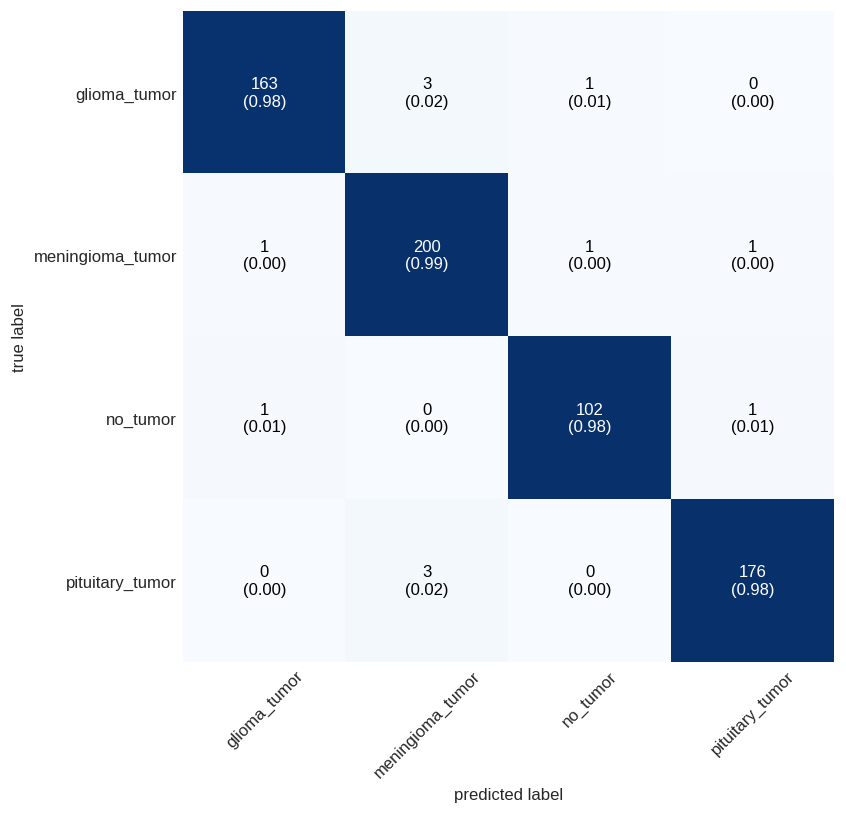

In [46]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(7,8))
confMatrix = confusion_matrix(y_true=y_test_label,y_pred=y_pred)
plot_confusion_matrix(conf_mat = confMatrix,class_names = [yDict[i] for i in range(4)],show_normed=True,axis=ax)
plt.show()

# References

[1] K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.